In [1]:
import numpy as np
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets

import diff_gaussian_rasterization
import diff_gaussian_rasterization_batched as dgrb
import torch
import pyquaternion
import os
import math
import glm
import matplotlib.pyplot as plt
from plyfile import PlyData, PlyElement

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def open_ply(file_path, max_points=1_000_000):
    file_path = os.path.expanduser(file_path)
    with open(file_path, 'rb') as f:
        plydata = PlyData.read(f)

    vertexes = plydata['vertex']

    print("n points:", len(vertexes))

    if max_points is not None:
        vertexes = vertexes[:max_points]

    scale_0 = np.array(vertexes['scale_0'])
    scale_1 = np.array(vertexes['scale_1'])
    scale_2 = np.array(vertexes['scale_2'])

    scale = np.exp(np.array([scale_0, scale_1, scale_2]).T)

    x = np.array(vertexes['x'])
    y = np.array(vertexes['y'])
    z = np.array(vertexes['z'])

    means3D = np.array([x, y, z]).T

    r = np.array(vertexes['f_dc_0'])
    g = np.array(vertexes['f_dc_1'])
    b = np.array(vertexes['f_dc_2'])

    colors = sigmoid(np.array([r, g, b]).T)

    rot_0 = np.array(vertexes['rot_0'])
    rot_1 = np.array(vertexes['rot_1'])
    rot_2 = np.array(vertexes['rot_2'])
    rot_3 = np.array(vertexes['rot_3'])

    rotations = np.array([rot_0, rot_1, rot_2, rot_3]).T

    opacity = sigmoid(np.array(vertexes['opacity']))

    return  {
        "means3D": means3D,
        "scale": scale,
        "colors": colors,
        "rotations": rotations,
        "opacity": opacity
    }


In [4]:
device = torch.device("cuda")

# # generate a random point cloud
# C = 3
# B = 1
# N = 100
# means3D = torch.cat(
#     [
#         torch.rand(B, N, 1, dtype=torch.float32, device=device) * 2 - 1,
#         torch.rand(B, N, 1, dtype=torch.float32, device=device) * 2 - 1,
#         torch.rand(B, N, 1, dtype=torch.float32, device=device) * 2 - 1,
#     ],
#     dim=2,
# )
# means2D = torch.zeros(B, N, 2, dtype=torch.float32, device=device)
# opacities = torch.ones(B, N, 1, dtype=torch.float32, device=device)
# scales = torch.ones(B, N, 3, dtype=torch.float32, device=device) * 0.1
# rotations = (
#     torch.from_numpy(np.stack([pyquaternion.Quaternion().elements for _ in range(N)]))
#     .to(torch.float32)
#     .to(device)
#     .expand(B, N, 4)
# )
# colors_precomp = torch.rand(B, N, C, dtype=torch.float32, device=device)

ply_data = open_ply("~/dtu_scan105_2d.ply", max_points=None)

# load a point cloud
C = ply_data["colors"].shape[1]
B = 1
N = ply_data["means3D"].shape[0]
means3D = torch.tensor(ply_data["means3D"], dtype=torch.float32, device=device).expand(B, N, 3)
means2D = torch.zeros(B, N, 2, dtype=torch.float32, device=device)
opacities = torch.tensor(ply_data["opacity"], dtype=torch.float32, device=device).unsqueeze(-1).expand(B, N, 1)
scales = torch.tensor(ply_data["scale"], dtype=torch.float32, device=device).expand(B, N, 3)
rotations = (
    torch.from_numpy(np.stack([pyquaternion.Quaternion().elements for _ in range(N)]))
    .to(torch.float32)
    .to(device)
    .expand(B, N, 4)
)
colors_precomp = torch.tensor(ply_data["colors"], dtype=torch.float32, device=device).expand(B, N, C)

FileNotFoundError: [Errno 2] No such file or directory: '~/dtu_scan105_2d.ply'

In [ ]:
print("means3D", means3D.shape)
print("means2D", means2D.shape)
print("opacities", opacities.shape)
print("scales", scales.shape)
print("rotations", rotations.shape)
print("colors_precomp", colors_precomp.shape)

means3D torch.Size([1, 215157, 3])
means2D torch.Size([1, 215157, 2])
opacities torch.Size([1, 215157, 1])
scales torch.Size([1, 215157, 3])
rotations torch.Size([1, 215157, 4])
colors_precomp torch.Size([1, 215157, 3])


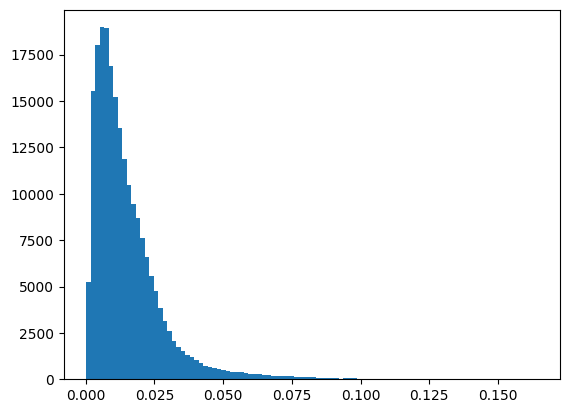

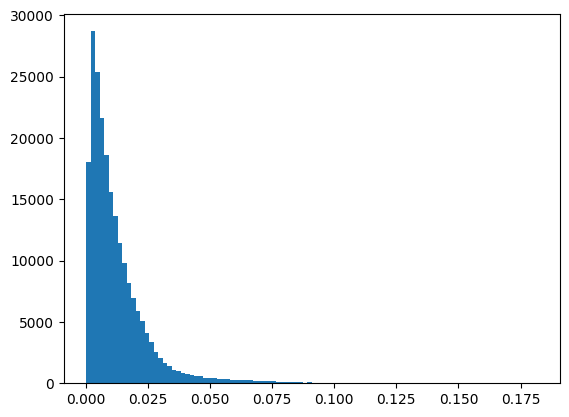

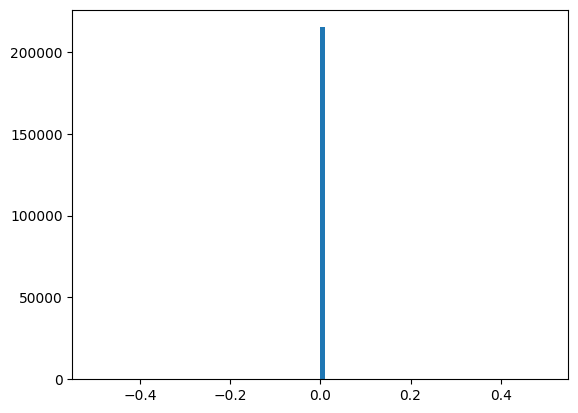

In [ ]:
plt.hist(ply_data["scale"][:, 0], bins=100)
plt.show()
plt.hist(ply_data["scale"][:, 1], bins=100)
plt.show()
plt.hist(ply_data["scale"][:, 2], bins=100)
plt.show()

In [ ]:
def get_eye(theta, phi, r):
    """Get the position of the camera.

    Args:
        theta (float): azimuth angle in radians
        phi (float): elevation angle in degrees
        r (float): distance of the camera from the origin

    Returns:
        torch.Tensor: position of the camera
    """
    s = [
            r * math.sin(phi) * math.cos(theta),
            r * math.cos(phi),
            r * math.sin(phi) * math.sin(theta),
    ]

    return [s[0], s[1], s[2]]



def toTensor(m: glm.mat4) -> torch.Tensor:
    return torch.tensor(m.to_list(), dtype=torch.float32, device=device)


@interact(
        fov=widgets.FloatSlider(min=1, max=179, value=60),
        azimuth=widgets.FloatSlider(min=-180, max=180, value=0),
        elevation=widgets.FloatSlider(min=-89, max=89, value=0),
        radius=widgets.FloatSlider(min=0.01, max=20, value=0),
)
def g(fov, azimuth, elevation, radius):
    FoVx = np.deg2rad(fov)
    FoVy = np.deg2rad(fov)

    eye = get_eye(np.deg2rad(azimuth), np.deg2rad(elevation), radius)

    print(eye)

    rasterizer = dgrb.GaussianRasterizer(
        dgrb.GaussianRasterizationSettings(
            image_channels=C,
            image_height=512,
            image_width=512,
            tanfovx=math.tan(FoVx * 0.5),
            tanfovy=math.tan(FoVy * 0.5),
            bg=torch.zeros(C, dtype=torch.float32, device=device),
            scale_modifier=1.0,
            projmatrix=toTensor(glm.perspective(FoVy, 1, 0.2, 100)),
            sh_degree=1,
            campos=torch.tensor([0, 0, 0], dtype=torch.float32, device=device),
            prefiltered=False,
            debug=True,
        )
    )

    rendered_image, radii = rasterizer(
        means3D=means3D,
        means2D=means2D,
        colors_precomp=colors_precomp,
        opacities=opacities,
        scales=scales,
        rotations=rotations,
        viewmatrixes=toTensor(
            glm.scale([1, 1, -1]) * glm.lookAt(eye, [0, 0, 0], [0, 0, 1])
        ).expand(B, 4, 4),
    )

    # display the rendered image
    image_batch = rendered_image.permute(0, 2, 3, 1).cpu().numpy()
    batches = image_batch.shape[0]
    fig, ax = plt.subplots(batches, 1, figsize=(10, 10), squeeze=False)
    for i in range(batches):
        ax[i, 0].imshow(image_batch[i])
        ax[i, 0].axis("off")

interactive(children=(FloatSlider(value=60.0, description='fov', max=179.0, min=1.0), FloatSlider(value=0.0, d…